This file extracts embeddings for all videos from the CLIP model.

In [1]:
#%% packages

import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity 

import torch
import cv2
import clip

from PIL import Image

In [2]:
#%% Load CLIP model

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
#%% video info

video_dir = '../data/MiT_original_videos'
video_name_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

In [4]:
#%% functions

def extract_frame_embedding(frame):
    """
    Extract embedding vector from a frame using CLIP model
    
    Args:
        frame: Input frame
        
    Returns:
        embedding: Embedding vector for this frame
    """
    frame_pil = Image.fromarray(frame)
    frame_preprocessed = preprocess(frame_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        frame_features = model.encode_image(frame_preprocessed)
        frame_embedding = frame_features.cpu().numpy()
    return frame_embedding.squeeze()

def extract_video_embedding(filename, num_frames=None, video_dir='../data/MiT_original_videos'):
    """
    Extract embeddings from evenly spaced frames in a video
    
    Args:
        filename: Video filename
        num_frames: Number of frames to extract
        video_dir: Directory containing videos
        
    Returns:
        video_embedding: Array of frame embeddings (frames x embedding_dim)
    """
    # Open video file
    video_path = os.path.join(video_dir, filename)
    cap = cv2.VideoCapture(video_path)
    # Calculate frame indices
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if num_frames is None:
        frame_indices = list(range(total_frames))
    else:
        frame_indices = [int(i * total_frames / num_frames) for i in range(num_frames)]
    
    # Extract frames and embeddings
    frames_embeddings = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            # Convert BGR (OpenCV default) to RGB (model expected)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Get embedding using extract_frame_embedding
            frame_embedding = extract_frame_embedding(frame_rgb)
            frames_embeddings.append(frame_embedding)
    
    cap.release()
    return np.array(frames_embeddings)

def similarity_video_embedding(all_video_embedding):
    """
    Calculate within and between video similarities
    
    Args:
        all_video_embedding: Dictionary of video embeddings
        
    Returns:
        within_df: DataFrame of within-video similarities
        between_df: DataFrame of between-video similarities
    """
    # Calculate centroids
    centroids = {video: np.mean(emb, axis=0) for video, emb in all_video_embedding.items()}
    
    # Calculate within-video similarities
    within_data = []
    for video, embeddings in all_video_embedding.items():
        centroid = centroids[video].reshape(1, -1)
        frame_similarities = cosine_similarity(embeddings, centroid).squeeze()
        for frame_id, similarity in enumerate(frame_similarities):
            within_data.append({
                'video_name': video,
                'index': frame_id,
                'value': similarity
            })
    
    # Calculate between-video similarities
    between_data = []
    centroid_matrix = np.array(list(centroids.values()))
    centroid_similarities = cosine_similarity(centroid_matrix)
    video_names = list(centroids.keys())
    
    for i, video1 in enumerate(video_names):
        for j, video2 in enumerate(video_names):
            if i != j:
                between_data.append({
                    'video_name': video1,
                    'index': video2, 
                    'value': centroid_similarities[i,j]
                })
    
    within_df = pd.DataFrame(within_data)
    between_df = pd.DataFrame(between_data)
    
    return within_df, between_df

def visualize_video_similarity(video_names, within_similarities, between_similarities, label='Index', display_image=False):
    """
    Visualize within and between video similarities
    
    Args:
        video_names: List of video names to display
        within_similarities: DataFrame of within-video similarities
        between_similarities: DataFrame of between-video similarities
        label: Label to display on x-axis ('Name' or 'Index')
        display_image: Whether to display video frames
        
    Returns:
        None
    """
    # Filter within similarities for selected videos
    within_filtered = within_similarities[within_similarities['video_name'].isin(video_names)].copy()
    within_filtered['type'] = 'within'

    # Filter between similarities for selected videos
    between_filtered = between_similarities[between_similarities['video_name'].isin(video_names)].copy()
    between_filtered['type'] = 'between'


    # Combine dataframes
    plot_data = pd.concat([
        within_filtered, between_filtered
    ])

    # Get video indices
    video_indices = {name: idx for idx, name in enumerate(video_names)}
    plot_data['video_index'] = plot_data['video_name'].map(video_indices)

    # Visualize: Scatter plot with jitter
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 20}) 
    
    # Add jitter to x-axis
    jitter = 0.2
    for stype, color in zip(['within', 'between'], ['#1f77b4', '#ff7f0e']):
        mask = plot_data['type'] == stype
        x = plot_data.loc[mask, 'video_index'] + np.random.uniform(-jitter, jitter, size=mask.sum())
        plt.scatter(x, plot_data.loc[mask, 'value'], 
                   alpha=0.3, label=stype, color=color, s=40) 

    plt.xlabel(f'Video {label} (randomly picked)', fontsize=20)
    plt.ylabel('Cosine similarity', fontsize=20)
    plt.title('Within and Between Video Similarities', fontsize=22)
    plt.ylim(0, 1.1)
    plt.legend(loc='lower right', fontsize=20, markerscale=2) 
    
    # Set x-axis labels
    if label == 'Index':
        labels = [str(video_name_list.index(name)) for name in video_names]
        plt.xticks(range(len(video_names)), labels, fontsize=20)
    else: 
        plt.xticks(range(len(video_names)), video_names, rotation=45, fontsize=20)
        
    # Display first frame of each video above x-axis if display_image is True
    if display_image:
        for i, name in enumerate(video_names):
            cap = cv2.VideoCapture(os.path.join(video_dir, name))
            ret, frame = cap.read()
            if ret:
                ax = plt.axes([0.1 + i*0.8/len(video_names), 0.7, 0.8/len(video_names), 0.2])
                ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                ax.axis('off')
            cap.release()
    
    plt.tight_layout()
    plt.show()


def visualize_dimension_distribution(df, n_dim=5, random_state=42):
    """
    Visualize distribution of randomly selected CLIP dimensions using violin plots
    
    Args:
        df: DataFrame containing CLIP embeddings
        n_dim: Number of dimensions to visualize
        random_state: Random seed for reproducibility
    """
    # Get CLIP feature columns
    clip_cols = [col for col in df.columns if col.startswith('CLIP_')]
    
    # Randomly select dimensions
    np.random.seed(random_state)
    selected_dims = np.random.choice(clip_cols, size=n_dim, replace=False)
    
    # Create violin plot
    plt.figure(figsize=(12, 6))
    plt.violinplot([df[dim] for dim in selected_dims])
    
    # Extract just the numbers from the dimension names
    dim_numbers = [dim.split('_')[1] for dim in selected_dims]
    plt.xticks(range(1, n_dim+1), dim_numbers)
    plt.xlabel('CLIP Dimension Index')
    plt.ylabel('Values')
    plt.title('Distribution of Randomly Picked Dimensions')
    
    plt.tight_layout()
    plt.show()

In [5]:
#%% main: 1. Extract embeddings for all videos

file_dir = '../data/annotations/NN/CLIP/'
file_name = 'all_video_embeddings.npy'
file_path = os.path.join(file_dir, file_name)
if not os.path.exists(file_path):
    all_video_embedding = {}

    for video_file in video_name_list:
        print(f"Processing {video_file}... ({video_name_list.index(video_file) + 1}/{len(video_name_list)})")
        video_embedding = extract_video_embedding(video_file, num_frames=None)
        all_video_embedding[video_file] = video_embedding

    # Save all video embeddings to npy file
    if not os.path.exists(file_path):
        os.makedirs(file_dir, exist_ok=True)

    np.save(file_path, all_video_embedding)
    print(f"Saved video embeddings to {file_path}")
else:
    print(f'Loading video embeddings from {file_path}')
    all_video_embedding = np.load(file_path, allow_pickle=True)
    all_video_embedding = all_video_embedding.item()

print(len(all_video_embedding.keys()))
print(all_video_embedding[video_name_list[0]].shape)

Loading video embeddings from ../data/annotations/NN/CLIP/all_video_embeddings.npy
244
(91, 512)


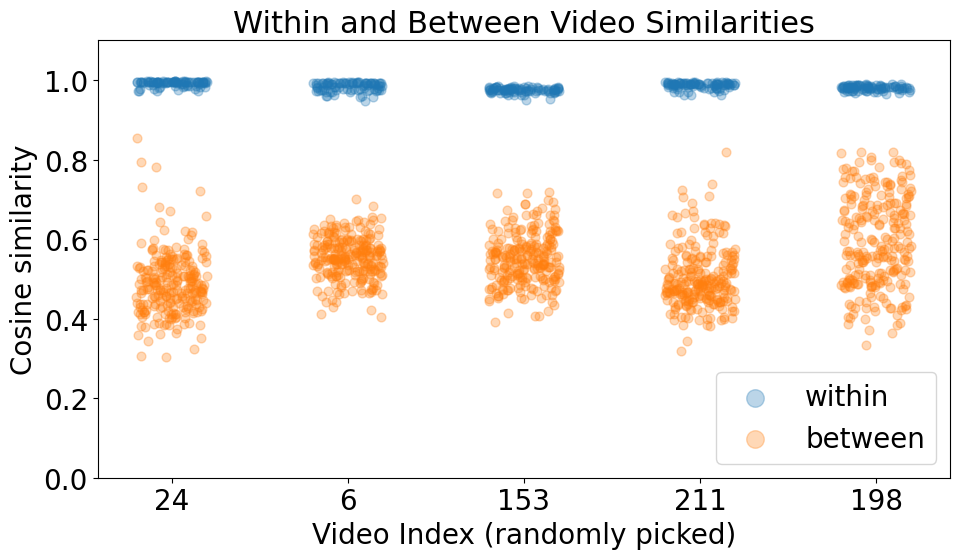

In [6]:
#%% main: 2. Validate the rationale of averaging frame embeddings to get video embeddings

# Compare within-video similarity and between-video similarity
within_similarities, between_similarities = similarity_video_embedding(all_video_embedding)

# visualize similarity of randomly-selected videos for demonstration
random_indices = np.random.RandomState(42).choice(len(video_name_list), size=5, replace=False)
selected_videos = [video_name_list[i] for i in random_indices]
visualize_video_similarity(selected_videos, within_similarities, between_similarities, label='Index', display_image=False)

In [7]:
#%% main: 3. Extract video-level embeddings

# Calculate averaged embedding for each video
video_embeddings_df = pd.DataFrame()

for video_name, frame_embeddings in all_video_embedding.items():
    mean_embedding = np.mean(frame_embeddings, axis=0)

    temp_df = pd.DataFrame([mean_embedding], columns=[f'CLIP_{i+1}' for i in range(len(mean_embedding))])
    temp_df['video_name'] = video_name
    
    video_embeddings_df = pd.concat([video_embeddings_df, temp_df], ignore_index=True)

cols = ['video_name'] + [col for col in video_embeddings_df.columns if col != 'video_name']
video_embeddings_df = video_embeddings_df[cols]

print("Shape of video embeddings dataframe:", video_embeddings_df.shape)
print("\nFirst few rows:")
print(video_embeddings_df.head())

# Save video embeddings dataframe to csv file
video_embeddings_df.to_csv(os.path.join(file_dir, 'CLIP_df.csv'), index=False)
print(f"Saved video embeddings dataframe to {os.path.join(file_dir, 'CLIP_df.csv')}")

Shape of video embeddings dataframe: (244, 513)

First few rows:
                                 video_name    CLIP_1    CLIP_2    CLIP_3  \
0   flickr-1-0-3-5-1-1-0-6-2810351106_1.mp4  0.399409  0.098144  0.336123   
1                      yt-lzsldb9fo70_4.mp4  0.511724 -0.047960  0.426349   
2  flickr-5-0-2-0-2-2-2-2-2450202222_18.mp4  0.502526  0.273570  0.394841   
3                     yt-9OU9ycaIiGM_35.mp4 -0.109598  0.005119  0.068176   
4                     yt-KZqqB7yoVYw_11.mp4  0.341397 -0.193583 -0.114195   

     CLIP_4    CLIP_5    CLIP_6    CLIP_7    CLIP_8    CLIP_9  ...  CLIP_503  \
0  0.212568  0.205054 -0.198757 -0.121979 -0.080687 -0.423351  ...  0.008833   
1  0.146953  0.139034 -0.386607  0.568859 -0.033577 -0.243532  ...  0.105952   
2  0.338357 -0.175621 -0.362369  0.142959  0.133354  0.278705  ...  0.537802   
3  0.243780 -0.063843  0.009338  0.054916 -0.050245 -0.000977  ...  0.143147   
4 -0.185415  0.072114 -0.271013 -0.335887 -0.246907 -0.439016  ...  0.02

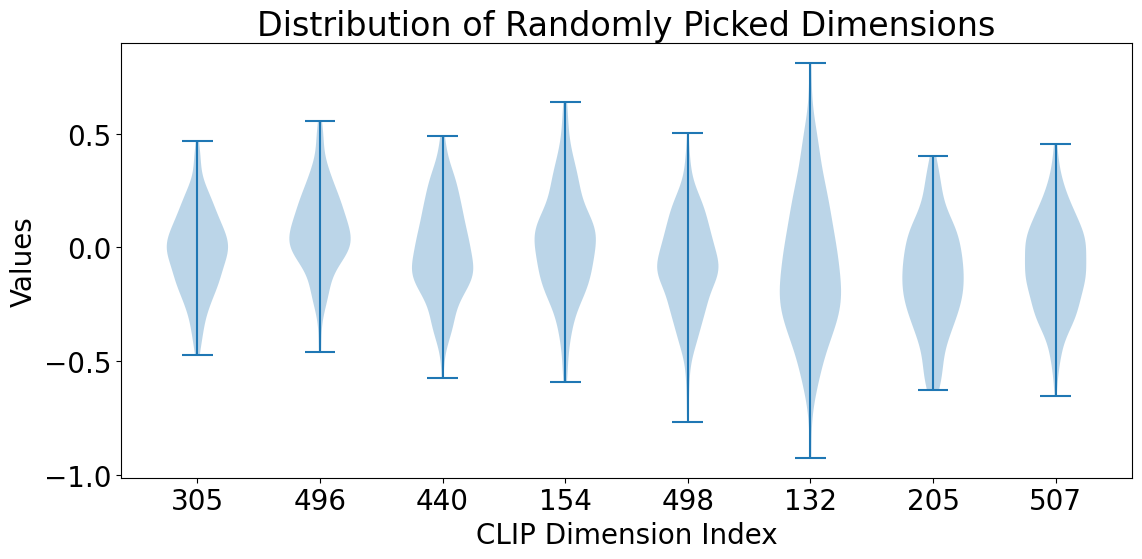

In [8]:
#%% main: 4. Visualize feature distribution
visualize_dimension_distribution(video_embeddings_df, n_dim=8)


Data size: 244 observations (videos)  
Feature space: 512 numerical (CLIP embeddings), with 1 indicator` video_name`   
As the feature space is larger than data size, in the following clustering task, I'll perform dimension reduction first.